# NOAA Data EDA

Within this notebook we explore the datasets provided by NOAA (National Oceanic and Atmospheric Administration) where we pull a total of __ datasets across __ different regions and aim to build a supervised learning model for predicting coral bleaching severity based on time series data.

An ambitious goal would be that we have would be to see if the first iteration of training a supervised learning model, whether we can understand the principles of an ARIMA model and attempt to build a unsupervised forecasting model to predict future bleaching patterns for coral at a global scale.

In [1]:
# Define Imports

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sys

sys.path.append('..')

from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import zscore
from load import load_noaa_station_data
from utils import create_noaa_date_column, create_noaa_seasonal_column

In [2]:
# NOAA dataset
# selected 3 regions with 3 stations each - 
# - specifically with different current levels of bleaching alerts - (HAS TO BE CHANGED)
urls = [
    # Great Barrier Reef Region
    "https://coralreefwatch.noaa.gov/product/vs/data/gbr_far_northern.txt",
    "https://coralreefwatch.noaa.gov/product/vs/data/torres_strait.txt",
    "https://coralreefwatch.noaa.gov/product/vs/data/gbr_northern.txt",
    
    # Polynesia Region
    "https://coralreefwatch.noaa.gov/product/vs/data/samoas.txt",
    "https://coralreefwatch.noaa.gov/product/vs/data/northern_cook_islands.txt",
    "https://coralreefwatch.noaa.gov/product/vs/data/hawaii.txt",
    
    # Caribbean Region
    "https://coralreefwatch.noaa.gov/product/vs/data/nicaragua.txt",
    "https://coralreefwatch.noaa.gov/product/vs/data/panama_atlantic_east.txt",
    "https://coralreefwatch.noaa.gov/product/vs/data/jamaica.txt"
]

Before we pull the entire dataset, it was important for us to pull a singular subset and understand the provided columns before we began merging the sets at a large scale. 

We have already pre-defined a function under the load.py file in order to extract the data completely in its original state and in its in order to extract their data into CSV format as each regions set is provided in a txt format.

We can take the first set in the list to load and read:

In [3]:
station_df = load_noaa_station_data(urls[0])
print(station_df.head())

   YYYY  MM  DD  SST_MIN  SST_MAX SST@90th_HS SSTA@90th_HS 90th_HS>0  \
0  1985  01  01  28.8200  29.2500     29.0300       0.7797    0.5600   
1  1985  01  02  28.8000  29.3300     29.0200       0.7135    0.5500   
2  1985  01  03  28.8000  29.2700     29.0300       0.7219    0.4900   
3  1985  01  04  28.7500  29.3100     29.0300       0.7103    0.4600   
4  1985  01  05  28.7100  30.6700     29.6400       1.3177    1.0500   

  DHW_from_90th_HS>1 BAA_7day_max           Station              Region  \
0             0.0000            0  Far Northern GBR  Great Barrier Reef   
1             0.0000            0  Far Northern GBR  Great Barrier Reef   
2             0.0000            0  Far Northern GBR  Great Barrier Reef   
3             0.0000            0  Far Northern GBR  Great Barrier Reef   
4             0.0000            0  Far Northern GBR  Great Barrier Reef   

   Latitude  Longitude  
0   -12.675      144.1  
1   -12.675      144.1  
2   -12.675      144.1  
3   -12.675     

From a high-level perspective, before we get into the column details and what they mean, it is important to understand that the set contains:

- environmental condition measurements - temperatures of the sea surface (columns SST_MIN, SST_MAX, SST@90th_HS)

- temperature anomalies - how much warmer/cooler the temperatures was found to be in comparisons to averaged values(columns SSTA@90th_HS)

- bleaching risk level: An integer scale from 0 to 7 ascending in the severity of bleaching levels as can be seen by the column BAA__7day_max

Now, in order to define the space that we are working in, let us outline each column stated above as a prerequisite and it's definitions:

- YYYY, MM, DD - The year, month, and date 

- SST_MIN - The minimum sea surface temperature for a specific date

- SST_MAX - The maximum sea surface temperature for a specific date

- SST@90th_HS - The temperature at the 90th percentile for a specific date

- SSTA@90th_HS - The temperature anomaly at the 90th percentile
  - What is a SSTA (Sea Surface Temperature Anomaly)? The difference between the observed sea surface temperature (SST) and the long-term average SST for that location and time of year.
  - A positive anomaly means the water is warmer than usual, while a negative anomaly means it's cooler than usual.

- 90th_HS>0 - The daily hotspot value at the 90th percentile - how much above the bleaching threshold the temperature is

- DHW_from_90th_HS>1 - degree heating weeks - something like accumulated heat stress over the past weeks??

- BAA_7day_max


Classic first move all columns non-null check:

In [4]:
print(station_df.isna().sum()) 

YYYY                  0
MM                    0
DD                    0
SST_MIN               0
SST_MAX               0
SST@90th_HS           0
SSTA@90th_HS          0
90th_HS>0             0
DHW_from_90th_HS>1    0
BAA_7day_max          0
Station               0
Region                0
Latitude              0
Longitude             0
dtype: int64


## Feature Engineering:

Create columns for:
- ISO Formatted Date
- Seasonal Grouping

In [5]:
create_noaa_date_column(station_df)
print(station_df['Date'].head)

<bound method NDFrame.head of 0       1985-01-01
1       1985-01-02
2       1985-01-03
3       1985-01-04
4       1985-01-05
           ...    
14747   2025-05-18
14748   2025-05-19
14749   2025-05-20
14750   2025-05-21
14751   2025-05-22
Name: Date, Length: 14752, dtype: datetime64[ns]>


In [6]:
create_noaa_seasonal_column(station_df)
print(station_df['Season'].head)

<bound method NDFrame.head of 0        Winter
1        Winter
2        Winter
3        Winter
4        Winter
          ...  
14747    Spring
14748    Spring
14749    Spring
14750    Spring
14751    Spring
Name: Season, Length: 14752, dtype: object>


In [7]:
print(station_df['SST_MIN'].describe())  
print(station_df['SST_MAX'].describe())  

count       14752
unique        826
top       28.4100
freq           41
Name: SST_MIN, dtype: object
count       14752
unique        771
top       29.5300
freq           51
Name: SST_MAX, dtype: object


In [8]:
print(station_df.columns)

Index(['YYYY', 'MM', 'DD', 'SST_MIN', 'SST_MAX', 'SST@90th_HS', 'SSTA@90th_HS',
       '90th_HS>0', 'DHW_from_90th_HS>1', 'BAA_7day_max', 'Station', 'Region',
       'Latitude', 'Longitude', 'Date', 'Season'],
      dtype='object')


In [9]:
print('duplicate rows: ',  station_df.duplicated().sum())
print('data types of columns: ', station_df.dtypes)

duplicate rows:  0
data types of columns:  YYYY                          object
MM                            object
DD                            object
SST_MIN                       object
SST_MAX                       object
SST@90th_HS                   object
SSTA@90th_HS                  object
90th_HS>0                     object
DHW_from_90th_HS>1            object
BAA_7day_max                  object
Station                       object
Region                        object
Latitude                     float64
Longitude                    float64
Date                  datetime64[ns]
Season                        object
dtype: object


Clear problem here, unexpected object values for expected float types. Clearly we need to convert the appropriate values:

In [10]:
numeric_cols = ['SST_MIN', 'SST_MAX', 'SST@90th_HS', 'SSTA@90th_HS', 
                '90th_HS>0', 'DHW_from_90th_HS>1', 'BAA_7day_max']

for col in numeric_cols:
    station_df[col] = pd.to_numeric(station_df[col], errors='coerce')

print('data types of columns: ', station_df.dtypes)

data types of columns:  YYYY                          object
MM                            object
DD                            object
SST_MIN                      float64
SST_MAX                      float64
SST@90th_HS                  float64
SSTA@90th_HS                 float64
90th_HS>0                    float64
DHW_from_90th_HS>1           float64
BAA_7day_max                   int64
Station                       object
Region                        object
Latitude                     float64
Longitude                    float64
Date                  datetime64[ns]
Season                        object
dtype: object


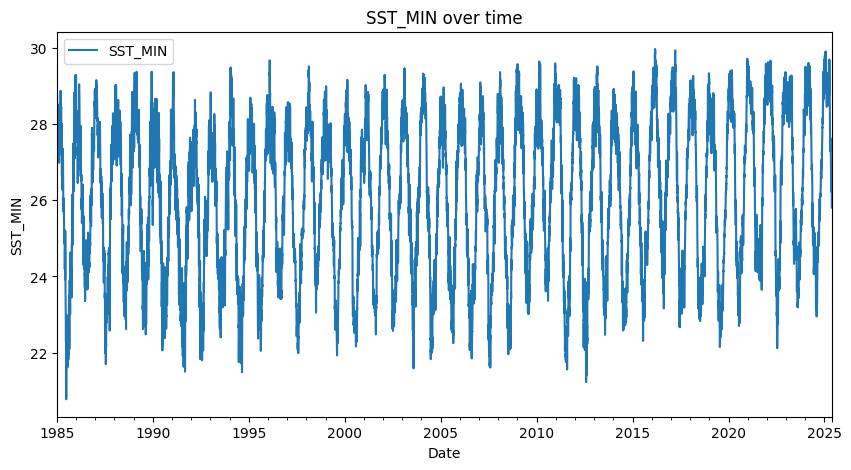

In [11]:
station_df.plot(x='Date', y='SST_MIN', kind='line', figsize=(10, 5))
plt.title('SST_MIN over time')
plt.xlabel('Date')
plt.ylabel('SST_MIN')
plt.show()

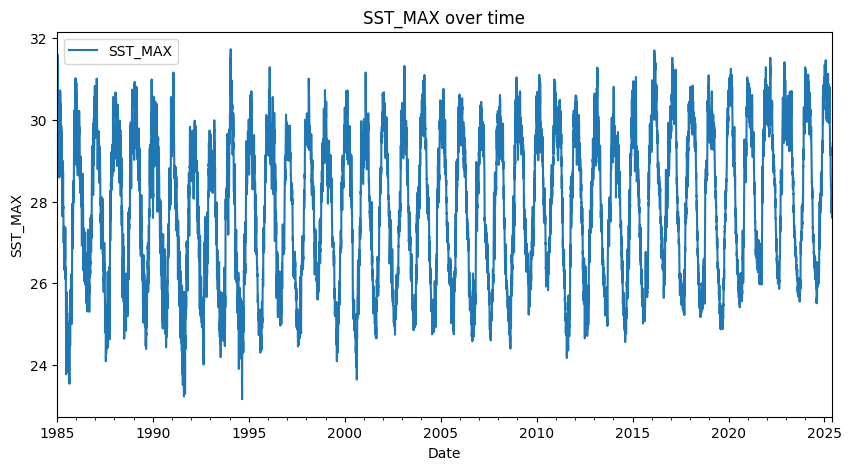

In [12]:
station_df.plot(x='Date', y='SST_MAX', kind='line', figsize=(10, 5))
plt.title('SST_MAX over time')
plt.xlabel('Date')
plt.ylabel('SST_MAX')
plt.show()

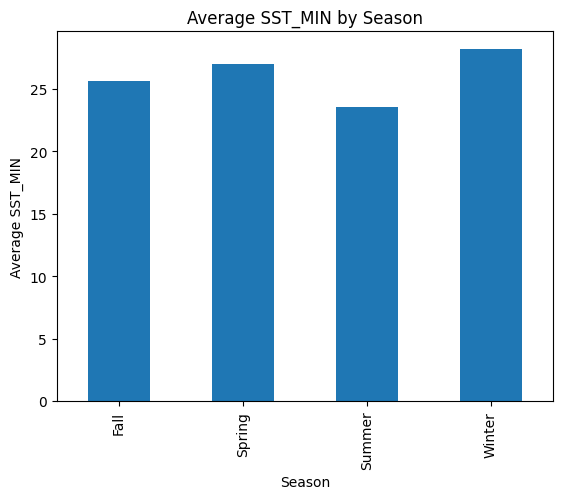

In [13]:
station_df.groupby('Season')['SST_MIN'].mean().plot(kind='bar')
plt.title('Average SST_MIN by Season')
plt.xlabel('Season')
plt.ylabel('Average SST_MIN')
plt.show()

### Increase Scale: Pull more sets and merge

Goal: Repeat process 

In [14]:
all_stations_data = []

for url in urls:
    try:
        station_df = load_noaa_station_data(url)
        station_name = station_df['Station'].iloc[0]
        print(f"Loaded {station_name} with {len(station_df)} records")
        all_stations_data.append(station_df)
    except Exception as e:
        print(f"Error loading {url}: {str(e)}")


if all_stations_data:
    combined_df = pd.concat(all_stations_data, ignore_index=True)
    
    create_noaa_date_column(combined_df)
    
    numeric_cols = ['SST_MIN', 'SST_MAX', 'SST@90th_HS', 'SSTA@90th_HS', 
                    '90th_HS>0', 'DHW_from_90th_HS>1', 'BAA_7day_max']
    
    existing_numeric_cols = [col for col in numeric_cols if col in combined_df.columns]
    
    for col in existing_numeric_cols:
        combined_df[col] = pd.to_numeric(combined_df[col], errors='coerce')
    
    create_noaa_seasonal_column(combined_df)
   
    # save
    combined_df.to_csv('../../data/noaa/pulled_data/coral_reef_data_combined.csv', index=False)
    print("\nCombined dataset saved to 'coral_reef_data_combined.csv'")
else:
    print("no stations loaded.")

Loaded Far Northern GBR with 14752 records
Loaded Torres Strait with 14750 records
Loaded Northern GBR with 14752 records
Loaded Samoas with 14751 records
Loaded Northern Cook Islands with 14752 records
Loaded Main Hawaiian Islands with 14752 records
Loaded Nicaragua with 14752 records
Loaded Panama Atlantic East with 14752 records
Loaded Jamaica with 14752 records

Combined dataset saved to 'coral_reef_data_combined.csv'


In [15]:
print(combined_df.isna().sum()) 
print(combined_df.info())
print(combined_df.head())

YYYY                  0
MM                    0
DD                    0
SST_MIN               0
SST_MAX               0
SST@90th_HS           0
SSTA@90th_HS          0
90th_HS>0             0
DHW_from_90th_HS>1    0
BAA_7day_max          0
Station               0
Region                0
Latitude              0
Longitude             0
Date                  0
Season                0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132765 entries, 0 to 132764
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   YYYY                132765 non-null  object        
 1   MM                  132765 non-null  object        
 2   DD                  132765 non-null  object        
 3   SST_MIN             132765 non-null  float64       
 4   SST_MAX             132765 non-null  float64       
 5   SST@90th_HS         132765 non-null  float64       
 6   SSTA@90th_HS        132765 non-

In [16]:
print('duplicate rows: ',  combined_df.duplicated().sum())
print('data types of columns: ', combined_df.dtypes)

duplicate rows:  0
data types of columns:  YYYY                          object
MM                            object
DD                            object
SST_MIN                      float64
SST_MAX                      float64
SST@90th_HS                  float64
SSTA@90th_HS                 float64
90th_HS>0                    float64
DHW_from_90th_HS>1           float64
BAA_7day_max                   int64
Station                       object
Region                        object
Latitude                     float64
Longitude                    float64
Date                  datetime64[ns]
Season                        object
dtype: object


### Correlations

In [17]:
numeric_df = combined_df.select_dtypes(include=['float64', 'int64'])
numeric_df = numeric_df.drop(columns=['Latitude'])
numeric_df = numeric_df.drop(columns=['Longitude'])

print(numeric_df.corr())

                     SST_MIN   SST_MAX  SST@90th_HS  SSTA@90th_HS  90th_HS>0  \
SST_MIN             1.000000  0.955770     0.962168      0.440562   0.565687   
SST_MAX             0.955770  1.000000     0.988047      0.503179   0.609390   
SST@90th_HS         0.962168  0.988047     1.000000      0.503613   0.611733   
SSTA@90th_HS        0.440562  0.503179     0.503613      1.000000   0.605641   
90th_HS>0           0.565687  0.609390     0.611733      0.605641   1.000000   
DHW_from_90th_HS>1  0.329932  0.348976     0.349374      0.396938   0.539210   
BAA_7day_max        0.606552  0.638771     0.643711      0.513599   0.830296   

                    DHW_from_90th_HS>1  BAA_7day_max  
SST_MIN                       0.329932      0.606552  
SST_MAX                       0.348976      0.638771  
SST@90th_HS                   0.349374      0.643711  
SSTA@90th_HS                  0.396938      0.513599  
90th_HS>0                     0.539210      0.830296  
DHW_from_90th_HS>1           

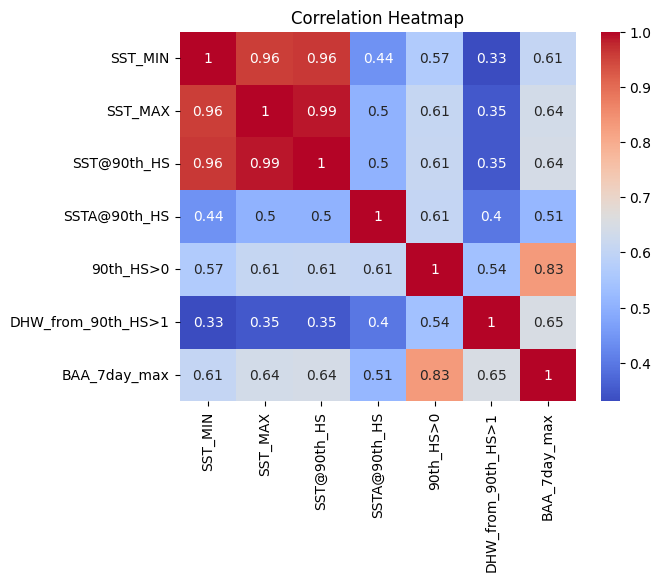

In [18]:
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

### Todo
Fill analysis and what we can undestand

### Analyse Distributions

Todo: fill

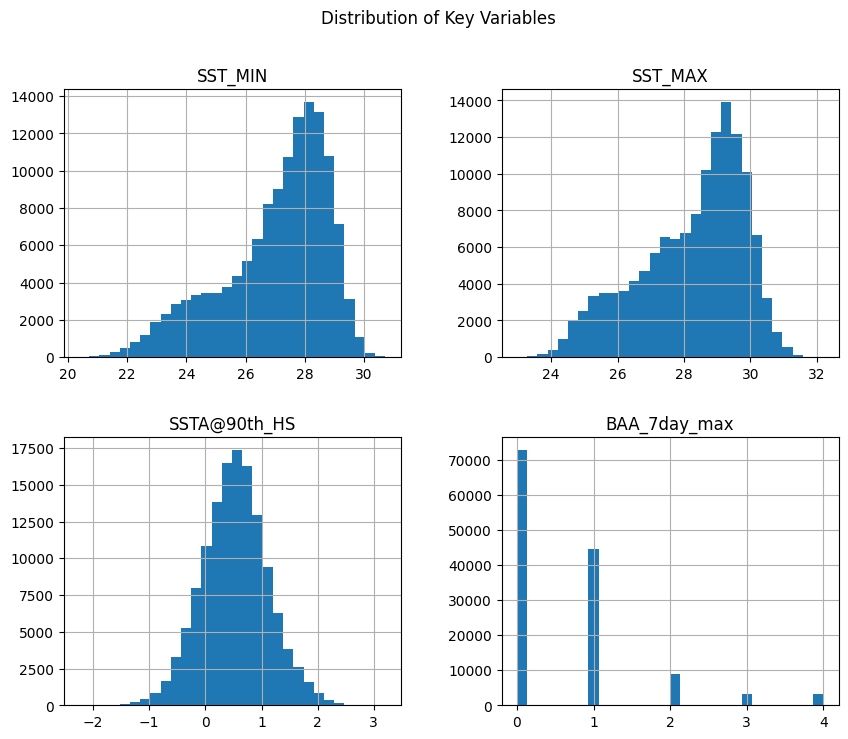

In [19]:
numeric_cols = ['SST_MIN', 'SST_MAX', 'SSTA@90th_HS','BAA_7day_max']
combined_df[numeric_cols].hist(bins=30, figsize=(10, 8))
plt.suptitle('Distribution of Key Variables')
plt.show()

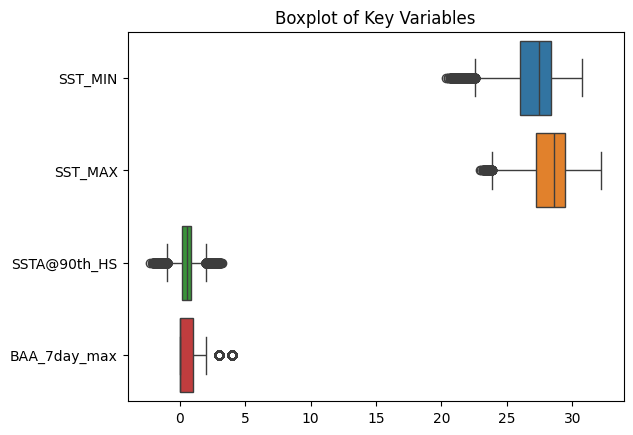

In [20]:
sns.boxplot(data=combined_df[numeric_cols], orient='h')
plt.title('Boxplot of Key Variables')
plt.show()

### Time Series Analysis
TODO See if we can spot any trends and strange behavior from time-dependant variables

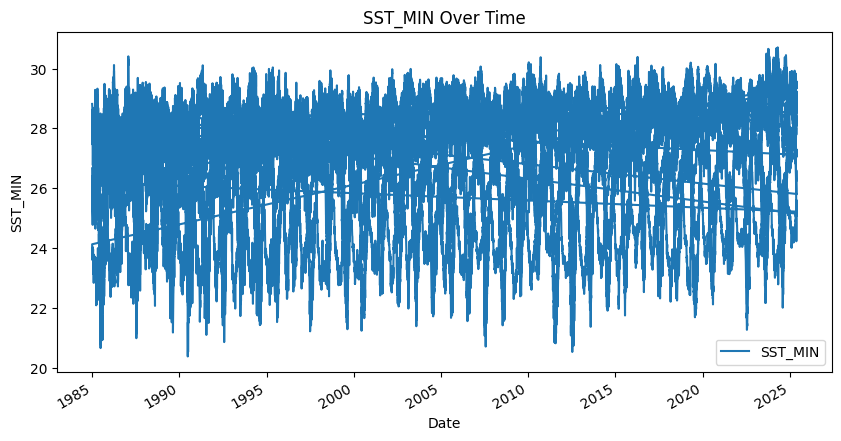

In [21]:
combined_df.plot(x='Date', y='SST_MIN', kind='line', figsize=(10, 5))
plt.title('SST_MIN Over Time')
plt.xlabel('Date')
plt.ylabel('SST_MIN')
plt.show()

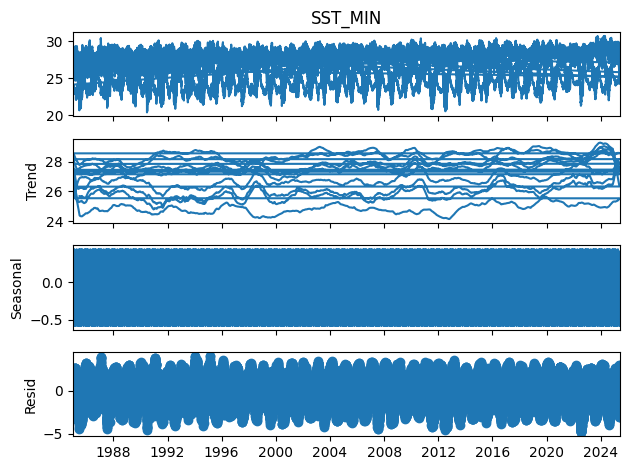

In [22]:
result = seasonal_decompose(combined_df.set_index('Date')['SST_MIN'], model='additive', period=365)
result.plot()
plt.show()

### Seasonal Analysis

TODO
We want to try and understand how variables change across seasons:

          SST_MIN    SST_MAX  SSTA@90th_HS  BAA_7day_max
Season                                                  
Fall    27.147828  28.372120      0.518896      0.719414
Spring  27.174882  28.320596      0.567885      0.638970
Summer  26.350602  27.763383      0.508295      0.456884
Winter  27.408421  28.542706      0.527376      0.745321


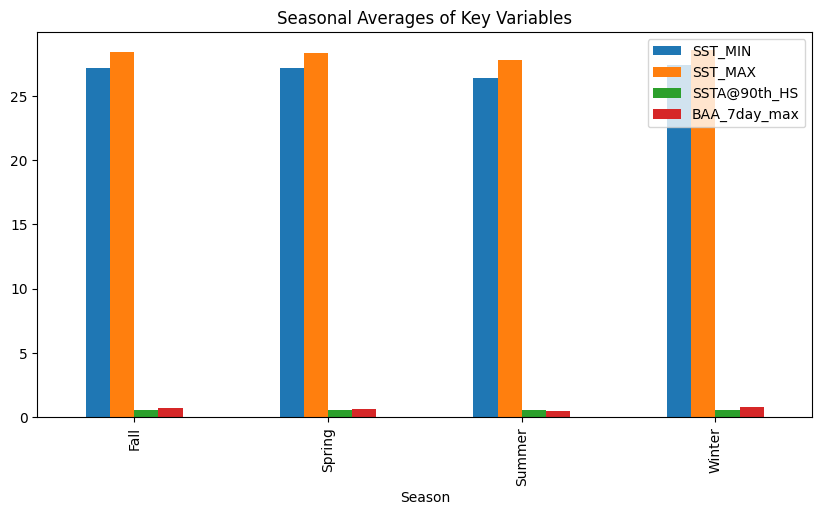

In [23]:
seasonal_means = combined_df.groupby('Season')[numeric_cols].mean()
print(seasonal_means)
seasonal_means.plot(kind='bar', figsize=(10, 5))
plt.title('Seasonal Averages of Key Variables')
plt.show()

## Outlier Detection
TODO Determine any extreme outliers and drop them but be careful here to understand what you are dropping and what that means

In [24]:
z_scores = combined_df[numeric_cols].apply(zscore)
outliers = (z_scores.abs() > 3).any(axis=1)
print(f"Number of outliers: {outliers.sum()}")

Number of outliers: 4004


## Feature Engineering
TODO Choose and document what you decide to add please

We decided to increase our scope by adding the new features:
- Temperature Range

In [25]:
combined_df['Temp_Range'] = combined_df['SST_MAX'] - combined_df['SST_MIN']

In [26]:
print(combined_df.head())

   YYYY  MM  DD  SST_MIN  SST_MAX  SST@90th_HS  SSTA@90th_HS  90th_HS>0  \
0  1985  01  01    28.82    29.25        29.03        0.7797       0.56   
1  1985  01  02    28.80    29.33        29.02        0.7135       0.55   
2  1985  01  03    28.80    29.27        29.03        0.7219       0.49   
3  1985  01  04    28.75    29.31        29.03        0.7103       0.46   
4  1985  01  05    28.71    30.67        29.64        1.3177       1.05   

   DHW_from_90th_HS>1  BAA_7day_max           Station              Region  \
0                 0.0             0  Far Northern GBR  Great Barrier Reef   
1                 0.0             0  Far Northern GBR  Great Barrier Reef   
2                 0.0             0  Far Northern GBR  Great Barrier Reef   
3                 0.0             0  Far Northern GBR  Great Barrier Reef   
4                 0.0             0  Far Northern GBR  Great Barrier Reef   

   Latitude  Longitude       Date  Season  Temp_Range  
0   -12.675      144.1 1985-01

## Station Analysis

TODO Compare the data sets across the different stations and regions

In [27]:
station_summary = combined_df.groupby('Station')[numeric_cols].mean()
print(station_summary)

                         SST_MIN    SST_MAX  SSTA@90th_HS  BAA_7day_max
Station                                                                
Far Northern GBR       26.099044  27.869871      0.577097      0.544604
Jamaica                27.695090  28.641477      0.512318      0.542570
Main Hawaiian Islands  24.824738  26.170428      0.274516      0.237324
Nicaragua              27.446114  28.604599      0.579038      0.916689
Northern Cook Islands  28.453909  29.572099      0.489467      0.837242
Northern GBR           25.795569  27.312260      0.542901      0.422044
Panama Atlantic East   27.819483  28.516975      0.561934      0.822668
Samoas                 28.276259  29.319807      0.628772      0.782388
Torres Strait          26.775775  28.238443      0.611689      0.653085


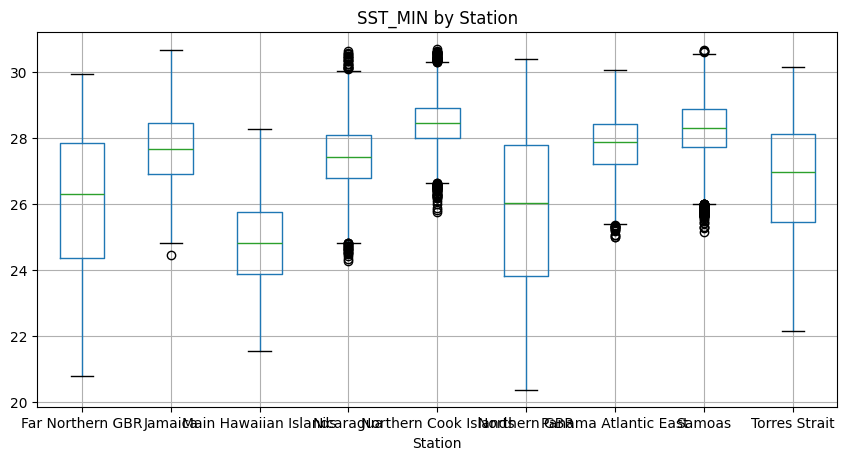

In [28]:
combined_df.boxplot(column='SST_MIN', by='Station', figsize=(10, 5))
plt.title('SST_MIN by Station')
plt.suptitle('')
plt.show()

## Data Wrangling

Goal: Prepare the dataset for training a machine learning model.

## Model Training